In [1]:
# The goal of this project is to understand stock dataset of a particular company and then analyse
# the dataset to predict the future price. The prediction of stock market is very cumbersome process. 
# So, in this work I am implementing Support Vector Regression method. I am using three models,
# Linear Regression, Radical Basic Function and Polynomial Regression models.

In [2]:
# Importing dependencies
import requests
import json
import csv
import numpy as np
import pandas as pd

In [3]:
# First of all I am fetching Data from Alpha Vantage API,
# I am fetching Stock data for Microsoft since last 20years to till date.

In [4]:
# Collecting stock data of Microsoft using Alpha Vantage API
CSV_URL ="https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=NR8HXOOB06DUO2M3&datatype=csv&outputsize=full"
with requests.Session() as s:
    download = s.get(CSV_URL)
    print(download)
    decoded_content = download.content.decode('utf-8')

    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    df = pd.DataFrame(cr)
df
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header
df.head()

<Response [200]>


,timestamp,open,high,low,close,volume
1,2022-07-06,263.7500,267.9900,262.4000,266.2100,23824419
2,2022-07-05,256.1600,262.9800,254.7400,262.8500,22971634
3,2022-07-01,256.3900,259.7700,254.6100,259.5800,22837692
4,2022-06-30,257.0500,259.5300,252.9000,256.8300,31730868
5,2022-06-29,257.5900,261.9700,255.7600,260.2600,20069839


In [5]:
# Once the data is collected I am applying Data Preprocessing methods to clean data.
# Data Type of the columns
dataTypeOfColumns = df.dtypes
print(dataTypeOfColumns)

0
timestamp    object
open         object
high         object
low          object
close        object
volume       object
dtype: object


In [6]:
# Checking if columns are unique column
columns = list(df)
for i in columns:
    print(i , "-", df[i].nunique() == df[i].count())

timestamp - True
open - False
high - False
low - False
close - False
volume - False


In [7]:
# Finding if there is any NaN value
df.isnull().values.any()

False

In [8]:
# Updating Datatypes of the columns
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.open=df.open.astype(float)
df.high=df.high.astype(float)
df.low=df.low.astype(float)
df.close=df.close.astype(float)
df.volume=df.volume.astype(int)
df.dtypes

0
timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
volume                int32
dtype: object

In [9]:
# By taking average of the high and low value I am calculating a mid or 
# average value of the stock for a particular day
df['average_value'] = df[['high', 'low']].mean(axis=1)
df.head(10)

,timestamp,open,high,low,close,volume,average_value
1,2022-07-06,263.750,267.99,262.40,266.21,23824419,265.195
2,2022-07-05,256.160,262.98,254.74,262.85,22971634,258.860
3,2022-07-01,256.390,259.77,254.61,259.58,22837692,257.190
4,2022-06-30,257.050,259.53,252.90,256.83,31730868,256.215
5,2022-06-29,257.590,261.97,255.76,260.26,20069839,258.865
6,2022-06-28,263.980,266.91,256.32,256.48,27380247,261.615
7,2022-06-27,268.205,268.30,263.28,264.89,24615114,265.790
8,2022-06-24,261.808,267.98,261.72,267.70,33923231,264.850
9,2022-06-23,255.570,259.37,253.63,258.86,25861449,256.500
10,2022-06-22,251.890,257.17,250.37,253.13,25961215,253.770


In [10]:
# Rearranging Columns
column_titles = ['timestamp','open','high','average_value','low','close','volume']
df.reindex(columns = column_titles)
df.head()

,timestamp,open,high,low,close,volume,average_value
1,2022-07-06,263.75,267.99,262.40,266.21,23824419,265.195
2,2022-07-05,256.16,262.98,254.74,262.85,22971634,258.860
3,2022-07-01,256.39,259.77,254.61,259.58,22837692,257.190
4,2022-06-30,257.05,259.53,252.90,256.83,31730868,256.215
5,2022-06-29,257.59,261.97,255.76,260.26,20069839,258.865


In [11]:
# sort by date
df_new = df.copy()
df_new = df_new.sort_values('timestamp')

# fix the date 
df_new.reset_index(inplace=True)
df_new.set_index("timestamp", inplace=True)

df_new.tail()

,index,open,high,low,close,volume,average_value
timestamp,,,,,,,
2022-06-29,5,257.59,261.97,255.76,260.26,20069839,258.865
2022-06-30,4,257.05,259.53,252.90,256.83,31730868,256.215
2022-07-01,3,256.39,259.77,254.61,259.58,22837692,257.190
2022-07-05,2,256.16,262.98,254.74,262.85,22971634,258.860
2022-07-06,1,263.75,267.99,262.40,266.21,23824419,265.195


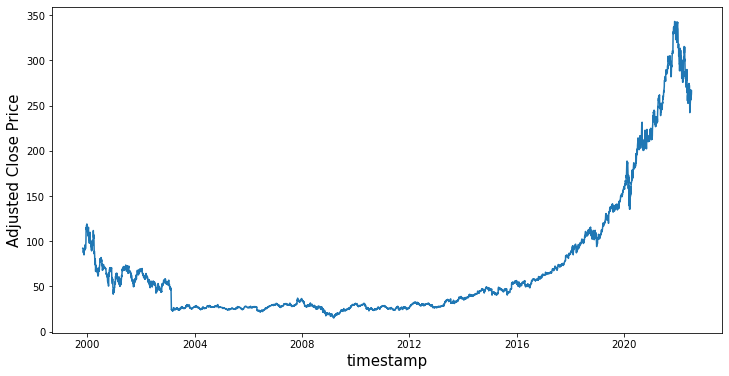

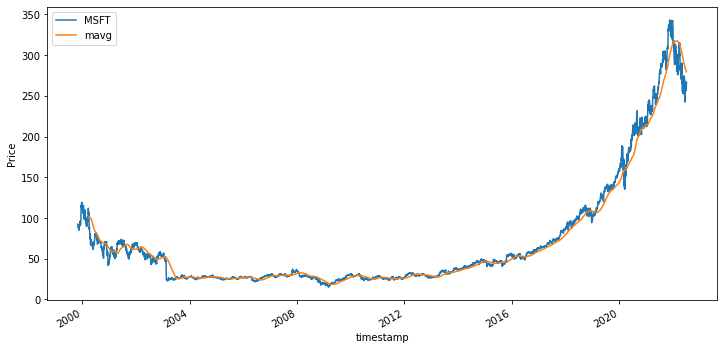

In [12]:
# Visualizing the training stock data
# for time series prediction, first sort the data by date and plotting curve with the rolling mean
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(df_new["close"])
plt.xlabel('timestamp',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()


# Rolling mean
close_px = df_new['close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='MSFT')
mavg.plot(label='mavg')
plt.xlabel('timestamp')
plt.ylabel('Price')
plt.legend()

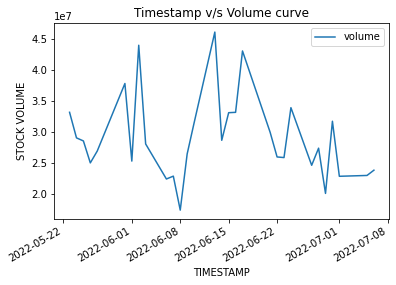

In [13]:
# Plotting curve TimeStamp v/s Volume
import matplotlib.pyplot as plt
%matplotlib inline
df_updated = df.head(30)
df_updated.plot(kind='line',x = "timestamp",y = "volume")
plt.title('Timestamp v/s Volume curve')
plt.xlabel('TIMESTAMP')
plt.ylabel('STOCK VOLUME')
plt.show()

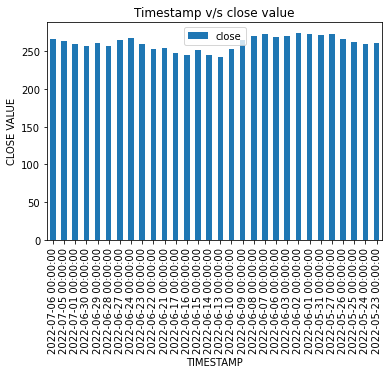

In [14]:
# Plotting Bar Graph between TimeStamp and Close Value
import matplotlib.pyplot as plt

df_updated = df.head(30)

df_updated.plot(kind='bar',x = "timestamp",y = "close")
plt.title('Timestamp v/s close value')
plt.xlabel('TIMESTAMP')
plt.ylabel('CLOSE VALUE')
plt.show()

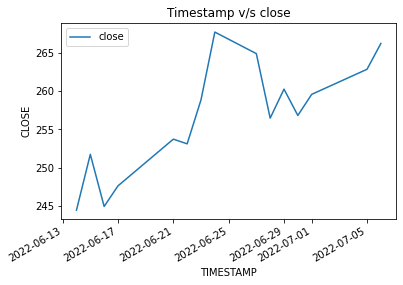

In [15]:
# Plotting curve TimeStamp v/s Close Value
# Here I am updating df_updated by collecting data of the recent 15 days.
df_updated = df.head(15)
df_updated.plot(kind='line',x = "timestamp",y = "close")
plt.title('Timestamp v/s close')
plt.xlabel('TIMESTAMP')
plt.ylabel('CLOSE')
plt.show()

In [16]:
# importing dependencies
from sklearn.svm import SVR 
%matplotlib inline

In [17]:
# Get data function
def get_data(df):  
    df.timestamp = df.timestamp.astype(str)
    data = df.copy()
    data['timestamp'] = data['timestamp'].str.split('-').str[2]
    data['timestamp'] = pd.to_numeric(data['timestamp'])
    return [ data['timestamp'].tolist(), data['close'].tolist() ] 
# Convert Series to list
dates, prices = get_data(df_updated)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [18]:
# Use of three models: linear, polynomial and radial basic function (default kernal for SVR)
def predict_prices(dates, prices, x):
    dates = np.reshape(dates,(len(dates), 1)) # convert to 1xn dimension
    x = np.reshape(x,(len(x), 1))
    
    svr_lin  = SVR(kernel='linear', C=1e3)
    svr_poly = SVR(kernel='poly', C=1e3, degree=4)
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.5)
    
    # Fit regression model
    svr_lin.fit(dates, prices)
    svr_poly.fit(dates, prices)
    svr_rbf.fit(dates, prices)
    
    plt.scatter(dates, prices, c='k', label='Data')
    plt.plot(dates, svr_lin.predict(dates), c='g', label='Linear model')
    plt.plot(dates, svr_rbf.predict(dates), c='r', label='RBF model')    
    plt.plot(dates, svr_poly.predict(dates), c='b', label='Polynomial model')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.show()
    
    return svr_rbf.predict(x)[0], svr_lin.predict(x)[0], svr_poly.predict(x)[0]

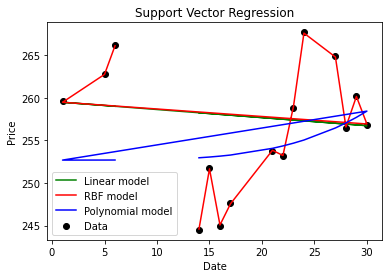

(256.9760570211904, 258.53172413806806, 252.79218991128488)


In [19]:
# Predicted Price for the date 11th May
predicted_price = predict_prices(dates, prices, [11])
print(predicted_price)

In [20]:
predicted_price = list(predicted_price)
print(predicted_price)

[256.9760570211904, 258.53172413806806, 252.79218991128488]


In [22]:
# Calculating Root Mean Square Error
from sklearn.metrics import mean_squared_error
from math import sqrt
actual_value = df['close'].at[1]
type(actual_value)
actual_value = actual_value.item()
# Actual_Value fetching from the dataframe
print('Actual Value: ', actual_value)
# Predicted_Value from Linear Regression model
predicted_value_RBFRegression = predicted_price[0]
predicted_value_linearRegression = predicted_price[1]
predicted_value_polynomial = predicted_price[2]
print('Predicted value from Radical Basic Model: ', predicted_value_RBFRegression)
print('Predicted value from Linear Regression Model: ', predicted_value_linearRegression)
print('Predicted value from Polynomial Model: ', predicted_value_polynomial)
actual_value1 = []
actual_value1.append(actual_value)
predicted_value1 = []
predicted_value1.append(predicted_value_linearRegression)
# Mean Square Error
mse = mean_squared_error(actual_value1, predicted_value1)
rmse = sqrt(mse)
print("Root Mean Square Error value: ", rmse)


Actual Value:  266.21
Predicted value from Radical Basic Model:  256.9760570211904
Predicted value from Linear Regression Model:  258.53172413806806
Predicted value from Polynomial Model:  252.79218991128488
Root Mean Square Error value:  7.6782758619319225


In [23]:
# The results shows that all the three models provides very close results to the actual value,
# when we do analysis on the last 15days data, 
# This proves Support Vector Regression method models provides very good accuracy and least root mean square values.
# References: 
# https://itnext.io/learning-data-science-predict-stock-price-with-support-vector-regression-svr-2c4fdc36662
# https://towardsdatascience.com/walking-through-support-vector-regression-and-lstms-with-stock-price-prediction-45e11b620650
 